<a href="https://colab.research.google.com/github/sureshmecad/Google-Colab/blob/master/Venture_Capital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 11: Python Business Analytics

See the Repository for Future Work: https://github.com/firmai/python-business-analytics or


Sign up to the mailing list:
https://mailchi.mp/ec4942d52cc5/firmai

# Venture Capital Allocation

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../.."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format='png', dpi=300)
    except:
        plt.savefig(fig_id + ".png", format='png', dpi=300)

# Training and visualizing

*You are a prinicpal in a venture capital firm. You are presented with a range of firms that have already received one round of funding and you have to decide what investment strategy you should follows. Your firm collects historical data on past acquisition and startup progress. Your investment strategy is defined by two main outcomes, whether a firm is acquired or not and whether the company has closed down or are still up an running. The data has been collected 5 years ago, apart from is_acquired and is_closed, that has been collected this year. As a result, five years ago, we did not know whether these firms would be acquired and/or closed*

You decide to allocate your money as follows:

1. Acquired & Open
    1. 50% of your capital alocation
    1. These companies seem to be somewhat overvalued in the market, other investors also believe they would be acquired and remain open and viable.
    1. Your strategy is to invest in these companies for the long run, you will only sell in 10-20 years. 
2. Not acquired & Open
    1. 50% of your capital allocation
    1. These firms are undervalued and has future acquisition potential. 
3. Not acquired & Closed
    1. 0% of your capital allocation
    1. Eventhough their low prices, these companies are not likley to achieve any success in the future

*In this analysis companies can't be acquired and closed*

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path
import pandas as pd

github_p = "https://raw.githubusercontent.com/Finance-781/FinML/master/Lecture%205%20-%20Decision%20Trees/Inclass/"

my_file = Path("data/data.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('data/data.csv')
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'data/data.csv')
    print("Done")
    

Be patient: loading from github (2 minutes)
Done


| Variable             | Definition                                               | Key           |
|----------------------|----------------------------------------------------------|---------------|
| company_id           | Company ID                                               |               |
| category_code        | Company category                                         |               |
| country_code         | Country                                                  | USA, NZL, other|
| state_code           | State                                                    | California, other |
| ipo                  | IPO                                                      | True or False |
| is_acquired          | Company is acquired or not                               | True or False |
| is_closed            | Company is closed or not                                 | True or False |
| age                  | Company age in days                                      |               |
| mba_degree           | Number of people with MBA degree associated with company |               |
| phd_degree           | Number of people with PhD degree associated with company |               |
| ms_degree            | Number of people with MS degree associated with company  |               |
| other_degree         | Number of other people associated with company           |               |
| offices              | Number of company's offices                              |               |
| average_funded       | Funds per round                                          |               |
| average_participants | Participants per round                                   |               |
| total_rounds         | Total number of rounds                                   |               |
| products_number      | Total number of products                                 |               |
| acquired_companies   | Total number of acquired companies                       |               |

In [ ]:
df.head()

,company_id,category_code,country_code,state_code,average_funded,total_rounds,average_participants,products_number,offices,acquired_companies,mba_degree,phd_degree,ms_degree,other_degree,ipo,is_acquired,is_closed,age
0,c:1,web,USA,other,1.325000e+07,3,3.0000,2.0,2.0,NaN,5.0,1.0,3.0,18.0,False,False,False,2998.0
1,c:1001,web,USA,California,5.000000e+06,1,3.0000,1.0,1.0,NaN,1.0,1.0,5.0,11.0,False,True,False,679.0
2,c:10014,mobile,USA,California,NaN,1,1.0000,1.0,1.0,1.0,NaN,1.0,2.0,6.0,False,True,False,943.0
3,c:10015,health,USA,California,1.361384e+07,5,3.8000,NaN,1.0,NaN,4.0,NaN,2.0,12.0,False,False,False,2284.0
4,c:100155,cleantech,USA,other,3.375098e+06,3,1.6667,NaN,1.0,NaN,2.0,1.0,3.0,6.0,False,False,False,4018.0


In [ ]:
df["Target"] = df["is_acquired"].astype(str) + df["is_closed"].astype(str)

df['Target'].unique()

cat_names = {'TrueFalse':1, 'TrueTrue':np.nan, 'FalseFalse':2, 'FalseTrue':3}

df["Target"] = df["Target"].replace(cat_names)

In [ ]:
df["average_funded"] = np.log(df["average_funded"]/1000000)

df = df.dropna(subset=["average_funded","total_rounds","Target"],axis=0) # remove rows where average funded and total_rounds is not avaialable

df['Target'].value_counts()

2.0    23986
1.0     2363
3.0     1748
Name: Target, dtype: int64

In [ ]:
## You can ignore this code block for the purpose of this lecture
## To make it easier to explain decision trees we will ensure that the number of samples in each category is similar, here we use random oversampling

# Divide by class
df_class_1 = df[df['Target'] == 1]
df_class_2 = df[df['Target'] == 2]
df_class_3 = df[df['Target'] == 3]


df_class_1_over = df_class_1.sample(len(df_class_2), replace=True).reset_index(drop=True)
#df_class_1_over[["average_funded","total_rounds"]] = (df_class_1_over[["average_funded","total_rounds"]].sample(len(df_class_1_over)).reset_index(drop=True) +df_class_1_over[["average_funded","total_rounds"]].sample(len(df_class_1_over)).reset_index(drop=True))/2
df_test_over = pd.concat([df_class_2, df_class_1_over], axis=0).reset_index(drop=True)

df_class_3_over = df_class_3.sample(len(df_class_2), replace=True).reset_index(drop=True)
#df_class_3_over[["average_funded","total_rounds"]] = (df_class_3_over[["average_funded","total_rounds"]].sample(len(df_class_3_over)).reset_index(drop=True) +df_class_3_over[["average_funded","total_rounds"]].sample(len(df_class_3_over)).reset_index(drop=True))/2


df = pd.concat([df_test_over, df_class_3_over], axis=0).reset_index(drop=True)


In [ ]:
df['Target'].value_counts()

1.0    23986
3.0    23986
2.0    23986
Name: Target, dtype: int64

In [ ]:
df.head()

,company_id,category_code,country_code,state_code,average_funded,total_rounds,average_participants,products_number,offices,acquired_companies,mba_degree,phd_degree,ms_degree,other_degree,ipo,is_acquired,is_closed,age,Target
0,c:1,web,USA,other,2.583998,3,3.0000,2.0,2.0,NaN,5.0,1.0,3.0,18.0,False,False,False,2998.0,2.0
1,c:10015,health,USA,California,2.611087,5,3.8000,NaN,1.0,NaN,4.0,NaN,2.0,12.0,False,False,False,2284.0,2.0
2,c:100155,cleantech,USA,other,1.216424,3,1.6667,NaN,1.0,NaN,2.0,1.0,3.0,6.0,False,False,False,4018.0,2.0
3,c:10018,analytics,USA,California,2.397895,3,4.3333,NaN,1.0,NaN,4.0,NaN,NaN,13.0,False,False,False,2922.0,2.0
4,c:100189,mobile,other,other,-1.386294,1,2.0000,NaN,1.0,NaN,NaN,NaN,NaN,NaN,False,False,False,3714.0,2.0


In [ ]:
df.drop("Target",axis="columns")[["average_funded","total_rounds"]].describe()

,average_funded,total_rounds
count,71958.000000,71958.000000
mean,0.535858,1.718711
std,2.045704,1.195006
min,-8.142187,1.000000
25%,-0.693147,1.000000
50%,0.871293,1.000000
75%,2.041220,2.000000
max,8.248665,15.000000


In [ ]:
X = df.drop("Target",axis="columns")[["average_funded","total_rounds"]].values # Like the Iris dataset, just highlight two variables
y = df.Target.values

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

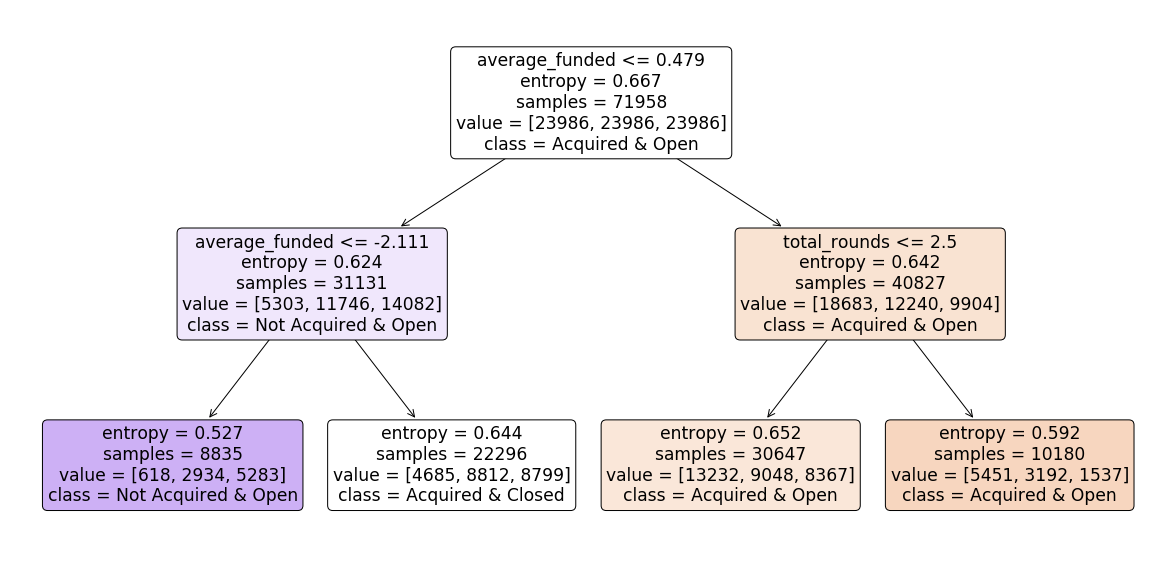

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))

lad = plot_tree(
        tree_clf,
        feature_names=["average_funded","total_rounds"],
        class_names=["Acquired & Open","Acquired & Closed","Not Acquired & Open","Not Acquired & Close"],
        rounded=True,
        filled=True,
    )


Saving figure decision_tree_decision_boundaries_plot


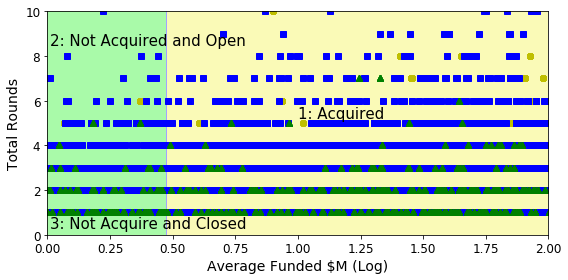

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 2, 0, 10], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.9, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.4)
    if plot_training:
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "yo", label="Acquired & Open")      # Yellow
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "bs", label="Not Acquired & Open")  # Blue
        plt.plot(X[:, 0][y==3], X[:, 1][y==3], "g^", label="Not Acquired & Close") # Green
        plt.axis(axes)
    if iris:
        plt.xlabel("Average Funded $M (Log)", fontsize=14)
        plt.ylabel("Total Rounds", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y, iris=True)
plt.text(0.01, 0.3, "3: Not Acquire and Closed", fontsize=15)
plt.text(1, 5.2, "1: Acquired", fontsize=15)
plt.text(0.01, 8.5, "2: Not Acquired and Open", fontsize=15)

## This is a tree with depth 3

save_fig("decision_tree_decision_boundaries_plot")
plt.show()


Average funding seems be a stronger driver of whether the firm has been acquired, while total rounds is important as to whether a non-acquired company is open or close. Remember this is predicting the state within a year.

# Predicting classes and class probabilities

In [ ]:
# Rounds, Funding
tree_clf.predict_proba([[0.25, 2]]) # More than two rounds - probably "Not Acquired and Open" according to model

array([[0.21012738, 0.39522784, 0.39464478]])

In [ ]:
tree_clf.predict([[0.25, 2]]) # Choosing the highest probability class

array([2.])

Saving figure min_samples_leaf_plot


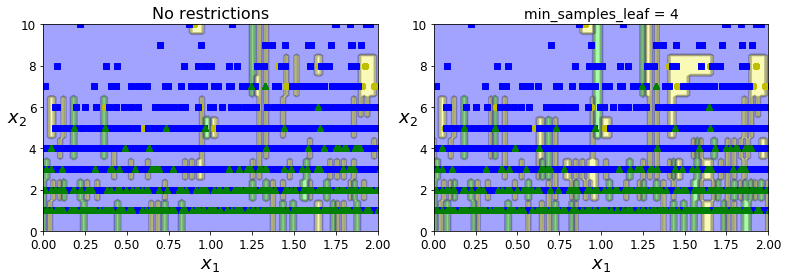

In [ ]:
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(X, y)
deep_tree_clf2.fit(X, y)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, X, y, axes=[0, 2, 0, 10], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, X, y, axes=[0, 2, 0, 10], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

save_fig("min_samples_leaf_plot")
plt.show()

Saving figure min_samples_leaf_plot


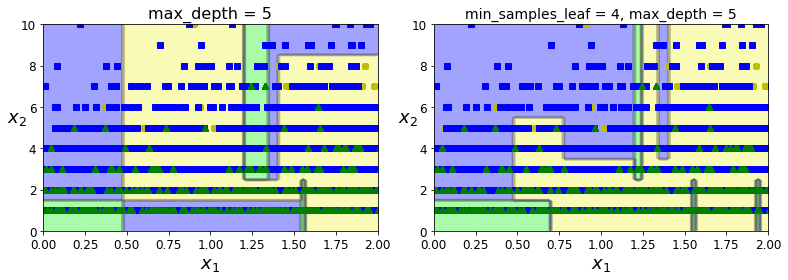

In [ ]:
deep_tree_clf1 = DecisionTreeClassifier(random_state=42,max_depth=5)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42,max_depth=6)
deep_tree_clf1.fit(X, y)
deep_tree_clf2.fit(X, y)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, X, y, axes=[0, 2, 0, 10], iris=False)
plt.title("max_depth = 5", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, X, y, axes=[0, 2, 0, 10], iris=False)
plt.title("min_samples_leaf = {}, max_depth = 5".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

save_fig("min_samples_leaf_plot")
plt.show()

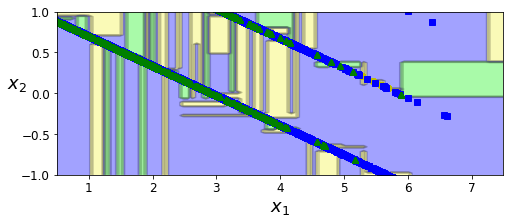

In [ ]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

Saving figure sensitivity_to_rotation_plot


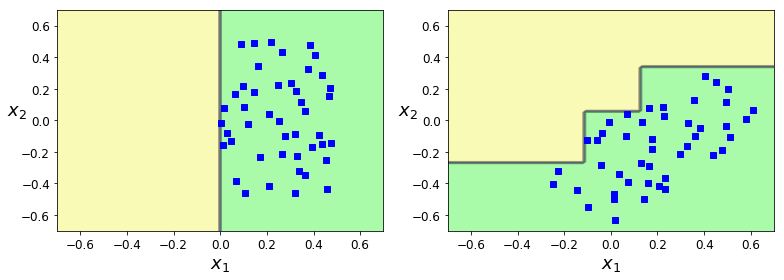

In [ ]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

save_fig("sensitivity_to_rotation_plot")
plt.show()